In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import os
import numpy as np
import random
import matplotlib.pyplot as plt
import time
from utils import set_seed, load_dataset, plot_feature_maps, plot_training_progress, evaluate_model
from transform import TensorAugment, SimpleResize
from models import WDMClassifierLarge,WDMClassifierMedium
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.manifold import TSNE
import matplotlib.cm as cm
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import numpy as np
import umap.umap_ as umap

In [2]:
# --- Set Device ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Load Model ---
model = WDMClassifierLarge().to(device)
checkpoint = torch.load("best_cnn_model_blur_tot_new.pt", map_location=device, weights_only=True)
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()

WDMClassifierLarge(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2))
    (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (13): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): Conv2d(512, 

Loading CDM data from /n/netscratch/iaifi_lab/Lab/msliu/CMD/data/IllustrisTNG/Maps_Mtot_IllustrisTNG_LH_z=0.00.npy...
CDM data shape: (15000, 256, 256)
WDM file not provided, creating CDM-only dataset
Created dataset with 8000 samples
Loading CDM data from /n/netscratch/iaifi_lab/Lab/msliu/CMD/data/Astrid/Maps_Mtot_Astrid_LH_z=0.00.npy...
CDM data shape: (15000, 256, 256)
WDM file not provided, creating CDM-only dataset
Created dataset with 8000 samples
Loading CDM data from /n/netscratch/iaifi_lab/Lab/msliu/CMD/data/EAGLE/Maps_Mtot_EAGLE_LH_z=0.00.npy...
CDM data shape: (15000, 256, 256)
WDM file not provided, creating CDM-only dataset
Created dataset with 8000 samples
Loading CDM data from /n/netscratch/iaifi_lab/Lab/msliu/CMD/data/SIMBA/Maps_Mtot_SIMBA_LH_z=0.00.npy...
CDM data shape: (15000, 256, 256)
WDM file not provided, creating CDM-only dataset
Created dataset with 8000 samples
CDM file not provided, creating WDM-only dataset
Loading WDM data from /n/netscratch/iaifi_lab/Lab/m

/n/home02/msliu/.conda/envs/env/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


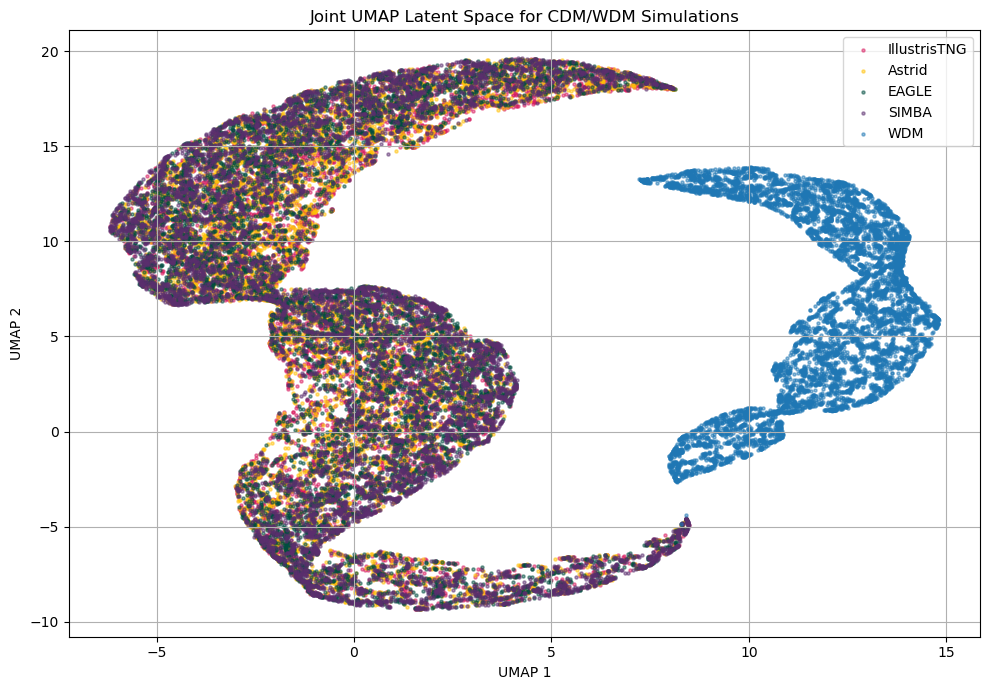

In [4]:
import numpy as np
import random
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import umap

# --- Prep for collection ---
all_features = []
all_labels = []
all_colors = []

# --- Configs ---
sims = ['IllustrisTNG', 'Astrid', 'EAGLE', 'SIMBA', 'WDM']
cs = ['#D81B60', '#FFC107', '#004D40', '#5B2E6E', 'tab:blue']
samples_per_sim = 8000

cdm = np.log1p(np.load(f'/n/netscratch/iaifi_lab/Lab/msliu/CMD/data/IllustrisTNG/Maps_Mtot_IllustrisTNG_LH_z=0.00.npy'))
wdm = np.log1p(np.load('/n/netscratch/iaifi_lab/Lab/msliu/Maps_Mtot_IllustrisTNG_WDM_z=0.00.npy'))
total = np.concatenate((cdm,wdm))
mean, std = total.mean(), total.std()
stats = {
    'mean': mean,
    'std': std
}

for cdm_model, colour in zip(sims, cs):
    if cdm_model == 'WDM':
        wdm_file = '/n/netscratch/iaifi_lab/Lab/msliu/Maps_Mtot_IllustrisTNG_WDM_z=0.00.npy'
        cdm_file = None
    else:
        cdm_file = f'/n/netscratch/iaifi_lab/Lab/msliu/CMD/data/{cdm_model}/Maps_Mtot_{cdm_model}_LH_z=0.00.npy'
        wdm_file = None

    
    
    all_indices = random.sample(range(15000), samples_per_sim)

    val_test_transform = SimpleResize(
        size=(256, 256),
        apply_log=True,
        normalize=stats
    )

    test_dataset = load_dataset(all_indices, transform=val_test_transform,
                                cdm_file=cdm_file, wdm_file=wdm_file)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False,
                             num_workers=1, pin_memory=True)

    features = []

    with torch.no_grad():
        for batch in test_loader:
            x, y = batch
            x = x.to(device)

            feats = model.features(x)
            pooled = nn.AdaptiveAvgPool2d((1, 1))(feats)
            flat_feats = torch.flatten(pooled, 1)

            features.append(flat_feats.cpu())

    features = torch.cat(features, dim=0).numpy()
    all_features.append(features)
    all_labels.extend([cdm_model] * features.shape[0])
    all_colors.extend([colour] * features.shape[0])

# --- Combine Features and Run UMAP ---
all_features = np.vstack(all_features)
reducer = umap.UMAP(n_components=2, random_state=42)
umap_results = reducer.fit_transform(all_features)

# --- Plot with Color Separation ---
plt.figure(figsize=(10, 7))

for cdm_model, colour in zip(sims, cs):
    mask = np.array(all_labels) == cdm_model
    plt.scatter(umap_results[mask, 0], umap_results[mask, 1],
                color=colour, alpha=0.5, s=5, label=cdm_model)

plt.title("Joint UMAP Latent Space for CDM/WDM Simulations")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('sim_latent_joint.png', dpi=300)
plt.show()


In [5]:
import numpy as np
import random
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import umap
from scipy.stats import gaussian_kde
from scipy.ndimage import gaussian_filter
try:
    import corner
    HAS_CORNER = True
except ImportError:
    HAS_CORNER = False
    print("corner library not found. Install with: pip install corner")

# --- Prep for collection ---
all_features = []
all_labels = []
all_colors = []

cdm = np.log1p(np.load(f'/n/netscratch/iaifi_lab/Lab/msliu/CMD/data/IllustrisTNG/Maps_Mtot_IllustrisTNG_LH_z=0.00.npy'))
wdm = np.log1p(np.load('/n/netscratch/iaifi_lab/Lab/msliu/Maps_Mtot_IllustrisTNG_WDM_z=0.00.npy'))
total = np.concatenate((cdm,wdm))
mean, std = total.mean(), total.std()
stats = {
    'mean': mean,
    'std': std
}

# --- Configs ---
sims = ['IllustrisTNG', 'Astrid', 'EAGLE', 'SIMBA', 'WDM']
cs = ['#D81B60', '#FFC107', '#004D40', '#5B2E6E', 'tab:blue']
samples_per_sim = 8000

for cdm_model, colour in zip(sims, cs):
    if cdm_model == 'WDM':
        wdm_file = '/n/netscratch/iaifi_lab/Lab/ccuestalazaro/DREAMS/Images/WDM/boxes/Maps_Mtot_IllustrisTNG_WDM_z=0.00.npy'
        cdm_file = None
    else:
        cdm_file = f'/n/netscratch/iaifi_lab/Lab/msliu/CMD/data/{cdm_model}/Maps_Mtot_{cdm_model}_LH_z=0.00.npy'
        wdm_file = None
    
    all_indices = random.sample(range(15000), samples_per_sim)
    val_test_transform = SimpleResize(
        size=(256, 256),
        apply_log=True,
        normalize=stats,
    )
    test_dataset = load_dataset(all_indices, transform=val_test_transform,
                                cdm_file=cdm_file, wdm_file=wdm_file)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False,
                             num_workers=1, pin_memory=True)
    
    features = []
    with torch.no_grad():
        for batch in test_loader:
            x, y = batch
            x = x.to(device)
            feats = model.features(x)
            pooled = nn.AdaptiveAvgPool2d((1, 1))(feats)
            flat_feats = torch.flatten(pooled, 1)
            features.append(flat_feats.cpu())
    
    features = torch.cat(features, dim=0).numpy()
    all_features.append(features)
    all_labels.extend([cdm_model] * features.shape[0])
    all_colors.extend([colour] * features.shape[0])

# --- Combine Features and Run UMAP ---
all_features = np.vstack(all_features)
n_components = 3  # Using 4 components for richer corner plot
reducer = umap.UMAP(n_components=n_components, random_state=42)
umap_results = reducer.fit_transform(all_features)

# Convert labels to numpy array for easier indexing
all_labels = np.array(all_labels)

Loading CDM data from /n/netscratch/iaifi_lab/Lab/msliu/CMD/data/IllustrisTNG/Maps_Mtot_IllustrisTNG_LH_z=0.00.npy...
CDM data shape: (15000, 256, 256)
WDM file not provided, creating CDM-only dataset
Created dataset with 8000 samples
Loading CDM data from /n/netscratch/iaifi_lab/Lab/msliu/CMD/data/Astrid/Maps_Mtot_Astrid_LH_z=0.00.npy...
CDM data shape: (15000, 256, 256)
WDM file not provided, creating CDM-only dataset
Created dataset with 8000 samples
Loading CDM data from /n/netscratch/iaifi_lab/Lab/msliu/CMD/data/EAGLE/Maps_Mtot_EAGLE_LH_z=0.00.npy...
CDM data shape: (15000, 256, 256)
WDM file not provided, creating CDM-only dataset
Created dataset with 8000 samples
Loading CDM data from /n/netscratch/iaifi_lab/Lab/msliu/CMD/data/SIMBA/Maps_Mtot_SIMBA_LH_z=0.00.npy...
CDM data shape: (15000, 256, 256)
WDM file not provided, creating CDM-only dataset
Created dataset with 8000 samples
CDM file not provided, creating WDM-only dataset
Loading WDM data from /n/netscratch/iaifi_lab/Lab/c

/n/home02/msliu/.conda/envs/env/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


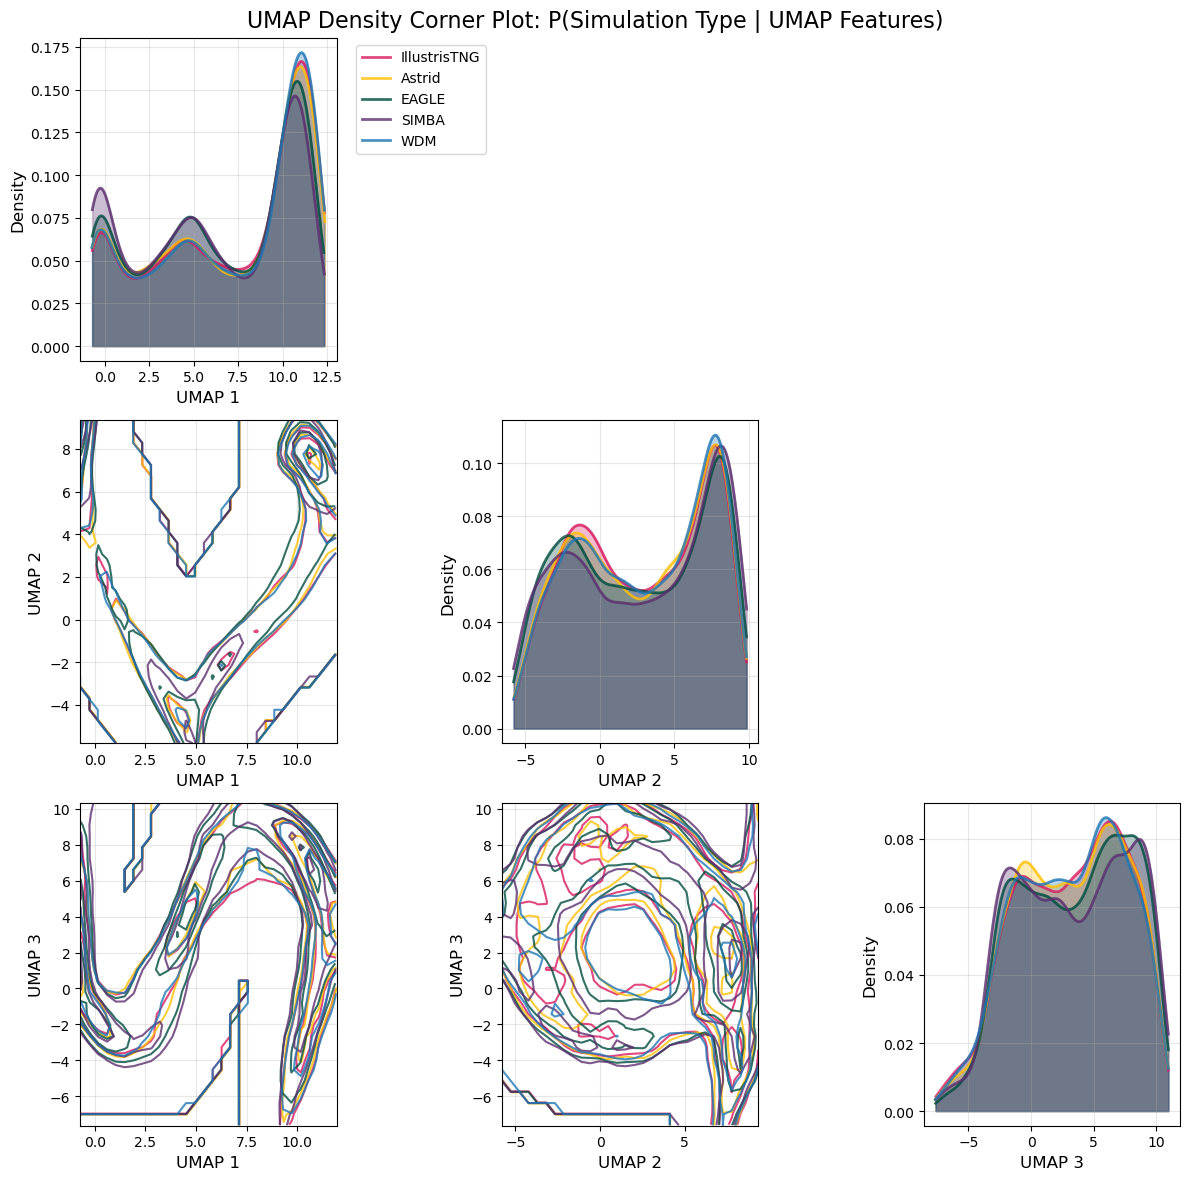

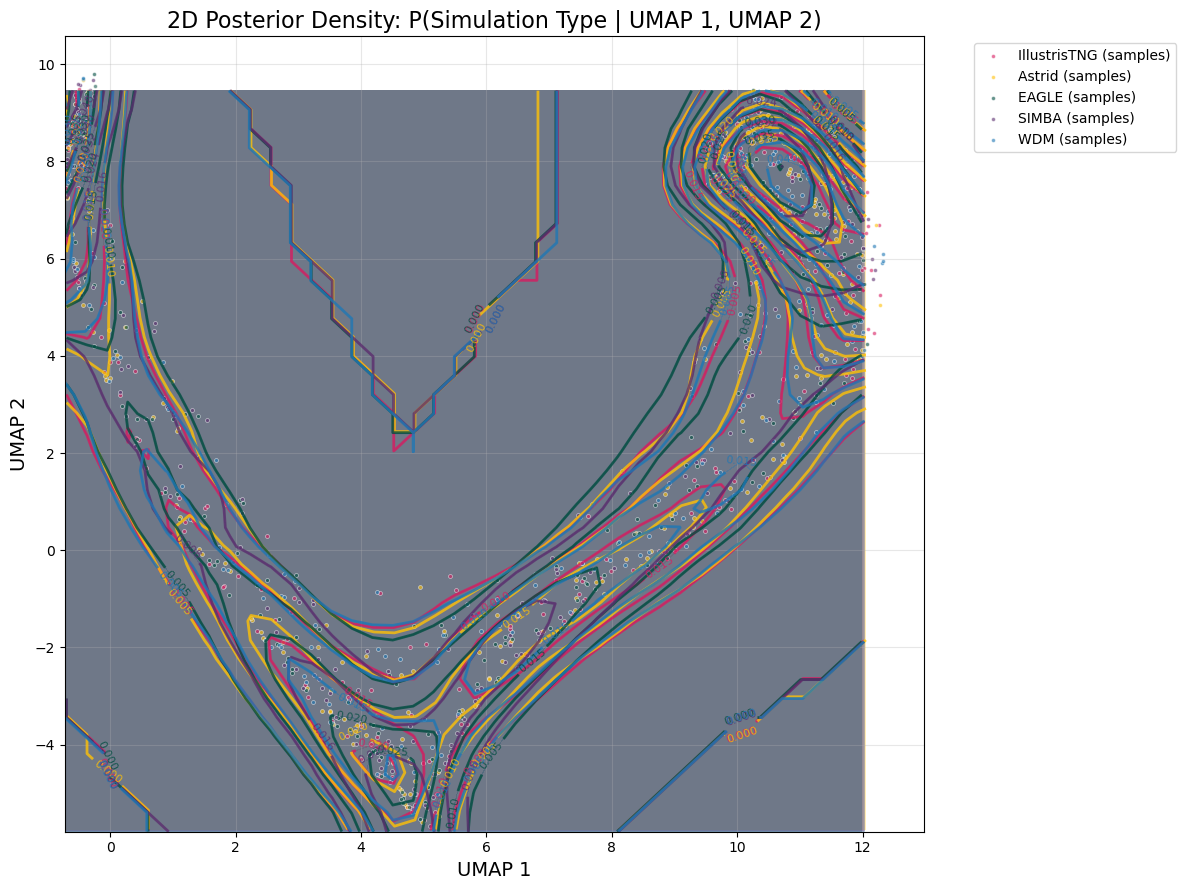


=== Posterior Distribution Statistics ===

IllustrisTNG:
  Sample size: 8000
  UMAP 1: μ=7.081, σ=4.229
  UMAP 2: μ=2.825, σ=4.338
  UMAP 3: μ=3.208, σ=4.237

Astrid:
  Sample size: 8000
  UMAP 1: μ=6.966, σ=4.265
  UMAP 2: μ=2.866, σ=4.384
  UMAP 3: μ=3.215, σ=4.207

EAGLE:
  Sample size: 8000
  UMAP 1: μ=6.570, σ=4.197
  UMAP 2: μ=2.676, σ=4.598
  UMAP 3: μ=3.481, σ=4.309

SIMBA:
  Sample size: 8000
  UMAP 1: μ=6.175, σ=4.274
  UMAP 2: μ=2.895, σ=4.743
  UMAP 3: μ=3.364, σ=4.465

WDM:
  Sample size: 8000
  UMAP 1: μ=7.080, σ=4.280
  UMAP 2: μ=2.963, σ=4.364
  UMAP 3: μ=3.167, σ=4.208


In [6]:
def estimate_2d_density(x, y, bins=50, smooth=1.0):
    """Estimate 2D density using histogram + gaussian smoothing"""
    H, xedges, yedges = np.histogram2d(x, y, bins=bins, density=True)
    H = gaussian_filter(H, sigma=smooth)
    X, Y = np.meshgrid(xedges[:-1], yedges[:-1])
    return X, Y, H.T

def estimate_1d_density(x, bins=50, smooth=1.0):
    """Estimate 1D density using KDE"""
    try:
        kde = gaussian_kde(x)
        x_range = np.linspace(x.min(), x.max(), 200)
        density = kde(x_range)
        return x_range, density
    except:
        # Fallback to histogram if KDE fails
        counts, edges = np.histogram(x, bins=bins, density=True)
        centers = (edges[:-1] + edges[1:]) / 2
        return centers, counts

# --- Create Density Corner Plot ---
fig, axes = plt.subplots(n_components, n_components, 
                        figsize=(4*n_components, 4*n_components))

# Define contour levels for consistency
contour_levels = 4

for i in range(n_components):
    for j in range(n_components):
        ax = axes[i, j]
        
        if i < j:  # Upper triangle - leave empty
            ax.set_visible(False)
            continue
            
        elif i == j:  # Diagonal - 1D density plots
            for cdm_model, colour in zip(sims, cs):
                mask = all_labels == cdm_model
                data = umap_results[mask, i]
                
                if len(data) > 10:  # Only plot if we have enough data
                    x_range, density = estimate_1d_density(data)
                    ax.plot(x_range, density, color=colour, 
                           linewidth=2, alpha=0.8, label=cdm_model)
                    ax.fill_between(x_range, density, alpha=0.3, color=colour)
            
            ax.set_xlabel(f'UMAP {i+1}', fontsize=12)
            ax.set_ylabel('Density', fontsize=12)
            ax.grid(True, alpha=0.3)
            
            if i == 0:  # Add legend only to first diagonal plot
                ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
                
        else:  # Lower triangle - 2D density contour plots
            for cdm_model, colour in zip(sims, cs):
                mask = all_labels == cdm_model
                x_data = umap_results[mask, j]  # x-axis dimension
                y_data = umap_results[mask, i]  # y-axis dimension
                
                if len(x_data) > 50:  # Only plot if we have enough data
                    try:
                        # Method 1: Using 2D histogram + smoothing
                        X, Y, density = estimate_2d_density(x_data, y_data, bins=30)
                        
                        # Create contour plot
                        contours = ax.contour(X, Y, density, levels=contour_levels, 
                                            colors=[colour], alpha=0.8, linewidths=1.5)
                        # ax.contourf(X, Y, density, levels=contour_levels, 
                        #            colors=[colour], alpha=0.2)
                        
                    except Exception as e:
                        print(f"Could not create density plot for {cdm_model}: {e}")
                        # Fallback: just plot a few sample points
                        sample_idx = np.random.choice(len(x_data), min(100, len(x_data)), replace=False)
                        ax.scatter(x_data[sample_idx], y_data[sample_idx], 
                                 color=colour, alpha=0.5, s=10, label=cdm_model)
            
            ax.set_xlabel(f'UMAP {j+1}', fontsize=12)
            ax.set_ylabel(f'UMAP {i+1}', fontsize=12)
            ax.grid(True, alpha=0.3)

plt.suptitle("UMAP Density Corner Plot: P(Simulation Type | UMAP Features)", 
             fontsize=16, y=0.98)
plt.tight_layout()
plt.savefig('umap_density_corner_plot.png', dpi=300, bbox_inches='tight')
plt.show()

# --- Alternative: Create a focused 2D density plot for the first two UMAP dimensions ---
fig, ax = plt.subplots(1, 1, figsize=(12, 9))

for cdm_model, colour in zip(sims, cs):
    mask = all_labels == cdm_model
    x_data = umap_results[mask, 0]
    y_data = umap_results[mask, 1]
    
    if len(x_data) > 50:
        # Create smooth density contours
        X, Y, density = estimate_2d_density(x_data, y_data, bins=40, smooth=1.5)
        
        # Plot filled contours (showing probability density regions)
        contour_filled = ax.contourf(X, Y, density, levels=8, 
                                   colors=[colour], alpha=0.3)
        
        # Plot contour lines (showing density levels)
        contour_lines = ax.contour(X, Y, density, levels=8, 
                                 colors=[colour], alpha=0.8, linewidths=2)
        
        # Add labels to contour lines
        ax.clabel(contour_lines, inline=True, fontsize=8, fmt='%.3f')

# Add some sample points for reference
for cdm_model, colour in zip(sims, cs):
    mask = all_labels == cdm_model
    sample_idx = np.random.choice(np.sum(mask), min(200, np.sum(mask)), replace=False)
    sample_mask = np.where(mask)[0][sample_idx]
    ax.scatter(umap_results[sample_mask, 0], umap_results[sample_mask, 1],
               color=colour, alpha=0.6, s=8, label=f'{cdm_model} (samples)', 
               edgecolors='white', linewidths=0.5)

ax.set_xlabel('UMAP 1', fontsize=14)
ax.set_ylabel('UMAP 2', fontsize=14)
ax.set_title('2D Posterior Density: P(Simulation Type | UMAP 1, UMAP 2)', fontsize=16)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('umap_2d_density_posterior.png', dpi=300, bbox_inches='tight')
plt.show()

# --- Print some statistics about the posterior distributions ---
print("\n=== Posterior Distribution Statistics ===")
for cdm_model in sims:
    mask = all_labels == cdm_model
    data = umap_results[mask]
    print(f"\n{cdm_model}:")
    print(f"  Sample size: {np.sum(mask)}")
    for dim in range(n_components):
        mean = np.mean(data[:, dim])
        std = np.std(data[:, dim])
        print(f"  UMAP {dim+1}: μ={mean:.3f}, σ={std:.3f}")